# [Summary of the tokenizers](https://huggingface.co/docs/transformers/main/en/tokenizer_summary)

正如我们在 [the preprocessing tutorial](https://huggingface.co/docs/transformers/main/zh/preprocessing) 中看到的那样, 对文本进行分词就是将其拆分为单词或子词, 然后通过查找表将其转换为 ids。将单词或子词转换为 ids 很简单, 因此在本总结中, 我们将聚焦将一段文本拆分成单词或子词(即对一段文本进行分词)。更具体地说, 我们将研究 Transformers 库中使用的三种主要类型的分词器: [Byte-Pair Encoding (BPE)](#Byte-Pair-Encoding-(BPE)), [WordPiece](#WordPiece) 和 [SentencePiece](#SentencePiece), 并展示哪种分词器类型被哪种模型使用。

请注意, 在每个模型页面上, 你可以查看相关分词器的文档, 以了解预训练模型使用了哪种分词器类型。例如, 如果我们查看 [BertTokenizer](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertTokenizer), 我们可以看到该模型使用 [WordPiece](#WordPiece)。

## Introduction
将一段文本拆分成更小的块是一项比看起来更难的任务, 并且有很多方式可以实现。例如, 让我们看看这个句子 "Don't you love 🤗 Transformers? We sure do."

对这段文本分词的一个简单方式是使用空格将其拆分, 这将得到:<br>
`["Don't", "you", "love", "🤗", "Transformers?", "We", "sure", "do."]`

这是一个明智的开始, 但是如果我们查看词元 "Transformers?" 和 "do.", 我们注意到标点符号被附着在单词 "Transformer" 和 "do" 的后面, 这是次优的。我们应该将标点符号考虑进来, 这样模型就不必学习一个单词和每个可能跟在其后的标点符号的不同组合, 这将使模型必须学习的组合数量激增。考虑标点符号, 对示例文本进行分词将得到:<br>
`["Don", "'", "t", "you", "love", "🤗", "Transformers", "?", "We", "sure", "do", "."]`

结果更好。然而, 该分词处理单词 "Don't" 的方式是有缺陷的。"Don't" 的含义是 "do not", 所以将其分词为 ["Do", "n't"] 更好。现在开始事情变得复杂, 部分原因是每个模型都有自己的分词类型。根据我们应用于文本分词的规则, 相同的文本会生成不同的分词输出。仅当您向预训练模型提供一个输入(使用与训练数据相同的规则对其进行分词)时, 预训练模型才能正常运行。

[spaCy](https://spacy.io/) 和 [Moses](http://www.statmt.org/moses/?n=Development.GetStarted) 是两个受欢迎的基于规则的分词器。将它们应用于我们的示例, spaCy 和 Moses 将输出类似下面的结果:<br>
`["Do", "n't", "you", "love", "🤗", "Transformers", "?", "We", "sure", "do", "."]`

可以看出, 这里使用了空格和标点符号的分词, 以及基于规则的分词。空格和标点符号分词以及基于规则的分词都是单词分词的例子, 其被宽松地定义为将句子拆分为单词。虽然将文本拆分为更小的块是最直观的方式, 但是这种分词方法用于大型文本语料库时, 会产生很多问题。在这种情况下, 空格和标点符号分词通常产生一个非常大的词汇表(使用的所有唯一单词和词元的集合)。例如, [Transformer XL](https://huggingface.co/docs/transformers/main/zh/model_doc/transformerxl) 使用空格和标点符号分词, 从而导致词汇表的大小为 267,735!

如此大的一个词汇表大小, 迫使模型有一个巨大的嵌入矩阵, 作为输入和输出层, 这会增加内存使用量, 也会提高时间复杂度。一般而言, transformers 模型的词汇表大小很少超过 50,000, 特别是如果它们只在单一语言上进行预训练。

因此, 如果简单的空格和标点符号分词令人不满意, 为什么不在字符级上进行简单地分词?

尽管字符分词非常简单, 并且将极大地降低了内存和时间复杂度, 但是这会让模型很难学习有意义的输入表示。例如, 学习字母 "t" 的有意义的上下文独立的表示比学习单词 "today" 更加困难。因此, <font color="red">字符分词经常伴随着性能的损失</font>。所以为了兼顾两全其美, transformers 模型在单词级别和字符级别分词之间采用了一种混合方案, 被称为**子词**分词([**subword** tokenization](#Subword-tokenization))。

## Subword tokenization
子词分词算法依赖于以下原则: 频繁使用的单词不应该被拆分成更小的子词, 但是罕见的单词应该被分解为有意义的子词。例如, "annoyingly" 可能被视为一个罕见的单词, 能被分解为 "annoying" 和 "ly"。"annoying" 和 "ly" 作为独立子词, 出现得更频繁, 与此同时单词 "annoyingly" 的含义由 "annoying" 和 "ly" 的复合含义保留。这在黏着语(如土耳其语)中尤其有用, 在这些语言中, 可以通过将子词串在一起来形成(几乎)任意长的复杂单词。

子词分词允许模型有一个合理的词汇表大小, 同时能学到有意义的上下文独立的表达。此外, 子词分词使模型能够处理从未见过的单词, 通过将它们分解为已知的子词。例如, [BertTokenizer](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertTokenizer) 对"I have a new GPU!"分词结果如下:

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
tokenizer.tokenize("I have a new GPU!")

`["i", "have", "a", "new", "gp", "##u", "!"]`

因为我们正在考虑不区分大小写的模型, 句子先被转换成小写字母形式。我们可以看到, 单词 ["i", "have", "a", "new"] 出现在分词器的词汇表中, 但是单词 "gpu" 不在其中。因此, 分词器将"gpu"拆分成已知的子词: ["gp" and "##u"]。"##" 表示词元的剩余部分, 应该附着在前一个词元的后面, 无空格(分词的解码或逆操作)。

另外一个例子, [XLNetTokenizer](https://huggingface.co/docs/transformers/main/en/model_doc/xlnet#transformers.XLNetTokenizer) 对之前的示例文本分词结果如下:

In [ ]:
from transformers import XLNetTokenizer
tokenizer = XLNetTokenizer.from_pretrained("xlnet/xlnet-base-cased")
tokenizer.tokenize("Don't you love 🤗 Transformers? We sure do.")

`["▁Don", "'", "t", "▁you", "▁love", "▁", "🤗", "▁", "Transform", "ers", "?", "▁We", "▁sure", "▁do", "."]`

当我们查看 [SentencePiece](#SentencePiece) 时, 回过头来解释这些"▁"符号的含义。正如所见, 罕见的单词 "Transformers" 被拆分为更高频的子词 "Transform" 和 "ers"。

现在让我们看看不同子词分词算法是如何工作的。请注意, 所有这些分词算法依赖于某些训练方式, 它们通常在语料库上完成, 相应的模型将在这些语料库上训练。

### Byte-Pair Encoding (BPE)
Byte-Pair Encoding (BPE) 来自于 [Neural Machine Translation of Rare Words with Subword Units (Sennrich et al., 2015)](https://arxiv.org/abs/1508.07909)。BPE 依赖于一个预分词器, 它将训练数据分割成单词。<font color="red">预分词可以是简单的空格分词, 例如 [GPT-2](https://huggingface.co/docs/transformers/main/zh/model_doc/gpt2), [RoBERTa](https://huggingface.co/docs/transformers/main/zh/model_doc/roberta)。更加先进的预分词方式包括了基于规则的分词, 例如 [XLM](https://huggingface.co/docs/transformers/main/zh/model_doc/xlm), [FlauBERT](https://huggingface.co/docs/transformers/main/zh/model_doc/flaubert)</font>(在大多数语言使用[Moses](http://www.statmt.org/moses/?n=Development.GetStarted)) <font color="red">或者 [GPT](https://huggingface.co/docs/transformers/main/zh/model_doc/gpt)</font>(使用 [spaCy](https://spacy.io/) 和 ftfy), 以统计训练语料库中每个单词的频次。

A) 在预分词以后, 生成了唯一单词的集合, 也确定了训练数据中每个单词出现的频次。B) 接下来, BPE 产生了一个基础词汇表, 包含唯一单词集合中出现的所有符号, 并学习合并规则, 合并基础词汇表中的两个符号形成一个新的符号。它会一直学习直到词汇表达到所需的词汇表大小。请注意, 所需的词汇表大小是在训练分词器之前定义的超参数。

例如, 假设在预分词后, A) 下面的单词集合以及他们的频数已确定:<br>
`("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)`

所以, 基础的词汇表是 ["b", "g", "h", "n", "p", "s", "u"]。将所有单词分割成基础词汇表中的符号, 得到:<br>
`("h" "u" "g", 10), ("p" "u" "g", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "u" "g" "s", 5)`

B) 接下来, BPE 统计每个可能的符号对的频数, 并挑选出出现最频繁的的符号对。在上面的例子中, "h" 后接 "u" 出现了 10 + 5 = 15 次 (10 次是出现了 10 次 "hug", 5 次是出现了 5 次 "hugs")。然而, 最频繁的符号对是 "u" 后接 "g", 总共出现了 10 + 5 + 5 = 20 次。因此, 分词器学到的第一个合并规则是合并所有的 "u" 后接 "g" 符号。接下来, "ug" 被添加到词汇表中。然后, 单词集合变成:<br>
`("h" "ug", 10), ("p" "ug", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "ug" "s", 5)`<br>

然后, BPE 统计出下一个最常见的符号对。也就是 "u" 后接 "n", 出现了 16 次。"u" 和 "n" 被合并成 "un", 并被添加到词汇表中。下一个最高频的符号对是 "h" 后接 "ug", 出现了15次。再次合并这对, "hug" 被添加到词汇表中。

在此阶段, 词汇表是 ["b", "g", "h", "n", "p", "s", "u", "ug", "un", "hug"], 我们的唯一单词集合表示为:<br>
`("hug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("hug" "s", 5)`

假设 Byte-Pair Encoding 在此时停止训练, 学到的合并规则将应用于新单词(只要这些新单词不包括 不在基础词汇表中的符号 即可)。例如, 单词 "bug" 会被分词为 ["b", "ug"], 但是 "mug" 会被分词为 ["`<unk>`", "ug"], 因为符号 "m" 不在基础词汇表中。通常, 单字母, 例如 "m", 不会被"`<unk>`"符号替换, 因为训练数据通常至少包含每个字母一次, 但是对于表情符号等非常特殊的字符, 这种情况(被"`<unk>`"符号替换)可能会发生。

如前所述, <font color="red">词汇表的大小, 即基础词汇表的大小 + 合并的数量, 是一个需要配置的超参数</font>。例如, [GPT](https://huggingface.co/docs/transformers/main/zh/model_doc/gpt) 的词汇表大小是 40,478, 因为它有着 478 个基础字符, 并选择在 40,000 次合并后停止训练。

#### Byte-level BPE
<font color="red">如果将所有 unicode 字符作为基础字符</font>, 包含所有可能的基础字符的基础词汇表可能会非常大。为了获得一个更好的基础词汇表, [GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) <font color="red"> 使用字节作为基础词汇表</font>, 这是一个巧妙的技巧, <font color="red">迫使基础词汇表的大小为 256, 同时确保每个基础字符都包含在词汇表中</font>。通过一些额外的规则处理标点符号, GPT2 的分词器能对每个文本进行分词, <font color="red">无需</font>`<unk>`符号。[GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) 的<font color="red">词汇表大小为 50,257, 对应于 256 字节的基础词元, 一个特殊的文本结束词元和通过 50,000 次合并学到的符号</font>。

### WordPiece
WordPiece 是子词分词算法, <font color="red">用于 [BERT](https://huggingface.co/docs/transformers/main/zh/model_doc/bert), [DistilBERT](https://huggingface.co/docs/transformers/main/zh/model_doc/distilbert) 和 [Electra](https://huggingface.co/docs/transformers/main/zh/model_doc/electra)</font>。这个算法在 [Japanese and Korean Voice Search (Schuster et al., 2012)](https://static.googleusercontent.com/media/research.google.com/ja//pubs/archive/37842.pdf) 中提出, 并与 BPE 非常相似。WordPiece 先初始化词汇表, 以包含训练数据中存在的每个字符, 然后逐步学习一个给定数量的合并规则。和 BPE 相比, <font color="red">WordPiece 不选择最高频的符号对, 而是选择(加入到词汇表后能最大化训练数据似然值的)符号对</font>。

所以这到底意味着什么? 参考前面的例子, 最大化训练数据的似然值, 等价于找到一个符号对, 其概率除以其第一个符号的概率, 接着除以第二个符号的概率, 在所有符号对中最大。例如, 如果 "ug" 除以 "u" 和 "g" 的概率, 大于任何其他符号对, "u" 后接 "g" 才会被合并。直觉上, WordPiece 与 BPE 略有不同, WordPiece 评估合并两个符号所造成的损失, 以确保这样做是值得的。

### Unigram
Unigram 是一个子词分词器算法, 由 [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (Kudo, 2018)](https://arxiv.org/pdf/1804.10959.pdf) 引入。和 BPE 或者 WordPiece 相比较, <font color="red">Unigram 将其基础词汇初始化为大量符号, 并逐步缩减每个符号以获得较小的词汇表</font>。例如, 基础词汇表可以对应所有预分词的单词, 以及最常见的子字符串。<font color="red">Unigram 没有直接用于 transformers 库中的任意模型, 但与 [SentencePiece](#SentencePiece) 一起联合使用</font>。

在每个训练的步骤, Unigram 算法在当前词汇表的训练数据上定义损失函数(通常定义为对数似然), 和一个 Unigram 语言模型。然后, 对词汇表中的每个符号, 算法会计算如果从词汇表中移除该字符, 总损失会增加多少。然后, Unigram 移除百分之 $p$ 的符号($p$ 通常为 10% 或 20%), 这些符号的 loss 增加是最低的, 也就是说, 这些符号在训练数据上对总损失影响最小。重复该过程, 直到词汇表达到所需大小。<font color="red">Unigram 算法始终保留基础字符, 以便可以对任何单词进行分词</font>。

<font color="red">因为 Unigram 不是基于合并规则(与 BPE 和 WordPiece 相比), 所以该算法在训练后有多种对新文本进行分词的方式</font>。例如, 如果一个已训练的 Unigram 分词器的词汇表如下:<br>
`["b", "g", "h", "n", "p", "s", "u", "ug", "un", "hug"]`

"hugs" 可以被分词成 ["hug", "s"], ["h", "ug", "s"] 或 ["h", "u", "g", "s"]。那么该选择哪一个? Unigram 在保存词汇表的基础上, 还保存训练语料库中每个词元的概率, 所以在训练后可以计算每个可能的分词结果的概率。该算法在实践中只是选择最有可能的分词结果, 但是也提供概率, 以根据它们的概率采样一个可能的分词结果。

这些概率由分词器训练时的损失定义。假设训练数据包含单词 $x_{1},\dots,x_{N}$, 一个单词$x_{i}$的所有可能的分词结果的集合定义为$S(x_{i})$, 则总损失定义为:
$$ \mathcal{L} = - \sum_{i=1}^N \log\left( \sum_{x \in S(x_i)} p(x) \right)$$

### SentencePiece
目前为止描述的所有分词算法都存在相同的问题: 假设输入文本使用空格分隔单词。然而, <font color="red">不是所有语言都使用空格分隔单词</font>。一个可能的解决方案是使用某种语言专用的预分词器, 例如 [XLM](https://huggingface.co/docs/transformers/main/en/model_doc/xlm) 使用一个特定的中文、日语和泰语的预分词器。为了更通用地解决这个问题, [SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing (Kudo et al., 2018)](https://arxiv.org/pdf/1808.06226.pdf) 将输入视为一个原始的输入流, 因此将空格包含在要使用的字符集中。然后, 它使用 BPE 或 Unigram 算法来构建合适的词汇表。

例如, [XLNetTokenizer](https://huggingface.co/docs/transformers/main/en/model_doc/xlnet#transformers.XLNetTokenizer) 使用 SentencePiece, <font color="red">这也是为什么在前面的例子中"▁"符号被包含在词汇表中</font>。用 SentencePiece 解码非常容易, 因为所有词元可以被连接起来, 然后将"▁"替换成空格。

库中使用 SentencePiece 的所有 transformers 模型都将其与 Unigram 组合使用。<font color="red">使用 SentencePiece 的模型示例是 [ALBERT](https://huggingface.co/docs/transformers/main/zh/model_doc/albert), [XLNet](https://huggingface.co/docs/transformers/main/zh/model_doc/xlnet), [Marian](https://huggingface.co/docs/transformers/main/zh/model_doc/marian) 和 [T5](https://huggingface.co/docs/transformers/main/zh/model_doc/t5)</font>。

## Usage
todo: https://huggingface.co/docs/transformers/main_classes/tokenizer

### 加载方法

- 从 Processor 加载 Tokenizer

In [ ]:
import torch
from transformers import AutoProcessor, Blip2Processor

device = "cuda" if torch.cuda.is_available() else "cpu"
path_blip2 = "./downloads/blip2-opt-2.7b/"
prompts = ["a photo of a cat", "a photo of a dog"]

In [ ]:
# image_processor 和 tokenizer 类名
processor_auto = AutoProcessor.from_pretrained(path_blip2)

In [ ]:
processor_auto.image_processor_class, processor_auto.tokenizer_class

In [ ]:
# blip-2 处理器, 图像处理器及分词器的输出 keys
processor_auto.model_input_names, processor_auto.image_processor.model_input_names, processor_auto.tokenizer.model_input_names

In [ ]:
# 1. 从 AutoProcessor 加载 tokenizer
inputs_text_pa = processor_auto.tokenizer(prompts, padding=True, return_tensors="pt")
inputs_text_pa

In [ ]:
# 2. 与前一个 cell 等效, 推荐
inputs_text_pa2 = processor_auto(text=prompts, padding=True, return_tensors="pt")

In [ ]:
processor_blip2 = Blip2Processor.from_pretrained(path_blip2)

In [ ]:
processor_blip2.image_processor_class, processor_blip2.tokenizer_class

In [ ]:
processor_blip2.model_input_names, processor_blip2.image_processor.model_input_names, processor_blip2.tokenizer.model_input_names

In [ ]:
# 3. 从 Blip2Processor 加载 tokenizer
inputs_text_pb = processor_blip2.tokenizer(prompts, padding=True, return_tensors="pt")

In [ ]:
# 4. 与前一个 cell 等效
inputs_text_pb2 = processor_blip2(text=prompts, padding=True, return_tensors="pt")

In [ ]:
# 验证
((inputs_text_pa.input_ids == inputs_text_pa2.input_ids).all().item() and 
 (inputs_text_pa.input_ids == inputs_text_pb.input_ids).all().item() and 
 (inputs_text_pa.input_ids == inputs_text_pb2.input_ids).all().item() and 
 (inputs_text_pa.attention_mask == inputs_text_pa2.attention_mask).all().item() and
 (inputs_text_pa.attention_mask == inputs_text_pb.attention_mask).all().item() and
 (inputs_text_pa.attention_mask == inputs_text_pb2.attention_mask).all().item())

- 直接加载 Tokenizer

In [ ]:
from transformers import AutoTokenizer, BertTokenizer, BertTokenizerFast

# "bert-base-uncased" 指一个特定的预训练 BERT 模型, 该模型已在大型语料库上进行训练。"uncased" 部分表示此模型不区分大小写, 这意味着它将大写和小写字母视为相同。
path_bert = "bert-base-uncased"
cache_dir = "./downloads/"
prompts = ["a photo of a cat", "a photo of a dog"]

In [ ]:
# 5. 从 AutoTokenizer 加载 tokenizer
tokenizer_auto = AutoTokenizer.from_pretrained(path_bert, cache_dir=cache_dir)
inputs_text_ta = tokenizer_auto(prompts, padding=True, return_tensors="pt")
inputs_text_ta

In [ ]:
# 6. 从 BertTokenizer 加载 tokenizer
tokenizer_bert = BertTokenizer.from_pretrained(path_bert, cache_dir=cache_dir)
inputs_text_tb = tokenizer_bert(prompts, padding=True, return_tensors="pt")

In [ ]:
# 7. 从 BertTokenizerFast 加载 tokenizer
tokenizer_bert_fast = BertTokenizerFast.from_pretrained(path_bert, cache_dir=cache_dir)
inputs_text_tbf = tokenizer_bert_fast(prompts, padding=True, return_tensors="pt")

In [ ]:
# 验证
((inputs_text_ta.input_ids == inputs_text_tb.input_ids).all().item() and 
 (inputs_text_ta.input_ids == inputs_text_tbf.input_ids).all().item() and 
 (inputs_text_ta.attention_mask == inputs_text_tb.attention_mask).all().item() and
 (inputs_text_ta.attention_mask == inputs_text_tbf.attention_mask).all().item())

In [ ]:
# todo: BertTokenizer.from_pretrained(BERTMODEL, cache_dir=CACHE_DIR, do_lower_case=True)
# https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer
# https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.from_pretrained

### 保存本地 & 本地加载

In [ ]:
# 将 processor 保存至本地
processor_auto.save_pretrained("./temp")
# 从本地 通过 AutoProcessor 加载 tokenizer
processor_local = AutoProcessor.from_pretrained("./temp/")
inputs_text_pl = processor_local.tokenizer(prompts, padding=True, return_tensors="pt")
# 从本地 通过 AutoTokenizer 加载 tokenizer
tokenizer_loal = AutoTokenizer.from_pretrained("./temp/")
inputs_text_tl = tokenizer_loal(prompts, padding=True, return_tensors="pt")
# 验证
((inputs_text_pl.input_ids == inputs_text_tl.input_ids).all().item() and
 (inputs_text_pl.input_ids == inputs_text_pa.input_ids).all().item() and
 (inputs_text_pl.attention_mask == inputs_text_tl.attention_mask).all().item() and
 (inputs_text_pl.attention_mask == inputs_text_pa.attention_mask).all().item())

### 输出

In [ ]:
# tokenizer = processor_auto.tokenizer # blip-2
tokenizer = tokenizer_auto # bert

In [ ]:
tokenizer(prompts[0], padding=True, return_tensors="pt") # 既适用于单提示本文输入, 又适用于批量提示文本输入

In [ ]:
tokenizer.encode_plus(prompts[0], padding=True, return_tensors="pt") # 仅适用于单提示本文输入

`input_ids`是一个整数列表，其中每个整数对应于分词后的输入序列中的一个词元

`token_type_ids`用于 BERT 等可以接受多个输入序列的模型, 例如涉及问答或自然语言推理的任务。在单序列任务中, `token_type_ids`中的所有值通常都设置为 0, 表示所有词元都属于同一输入序列。在双序列任务(例如问答)中, `token_type_ids`帮助模型区分来自第一个序列的词元和来自第二个序列的词元。对于第一个序列, `token_type_ids`设置为 0, 对于第二个序列, `token_type_ids`设置为 1。

`attention_mask`表示输入序列中的哪些词元应该被模型注意, 哪些词元应被忽略。通常, [PAD] 词元被掩码为 0, 以防止模型注意填充词元。这可确保模型将注意力聚焦于序列的实际内容。

refer to: https://medium.com/@manjindersingh_10145/sentiment-analysis-with-bert-using-huggingface-88e99deeec9a

### 查看词汇表

In [ ]:
# tokenizer = processor_auto.tokenizer # blip-2
tokenizer = tokenizer_auto # bert

In [ ]:
# 词汇表
tokenizer.vocab

### string, index seq, token seq 互转

In [ ]:
# tokenizer = processor_auto.tokenizer # blip-2
tokenizer = tokenizer_auto # bert

prompts = ["A photo of a Cat", "A photo of a Dog"]
# prompts = "Don't you love Transformers? We sure do."

#### string -> index seq

In [ ]:
if type(prompts) == str:
    ids_w = tokenizer(prompts).input_ids # 既适用于单提示本文输入, 又适用于批量提示文本输入
    print("string:", prompts, "--tokenizer--> index seq with special tokens =", ids_w)
    
    ids_wo = tokenizer(prompts, add_special_tokens=False).input_ids # 既适用于单提示本文输入, 又适用于批量提示文本输入
    print("\nstring:", prompts, "--tokenizer--> index seq without special tokens =", ids_wo)

    out = tokenizer.encode(prompts) # 仅适用于单提示本文输入
    print("\nstring:", prompts, "--encode--> index seq with special tokens =", out)
    print(out == ids_w)
    
    out = tokenizer.encode(prompts, add_special_tokens=False) # 仅适用于单提示本文输入
    print("\nstring:", prompts, "--encode--> index seq without special tokens =", out)
    print(out == ids_wo)

In [ ]:
if type(prompts) == list:
    ids_w = tokenizer(prompts).input_ids # 既适用于单提示本文输入, 又适用于批量提示文本输入
    print("string:", prompts, "-> index seq with special tokens =", ids_w)
    
    ids_wo = tokenizer(prompts, add_special_tokens=False).input_ids # 既适用于单提示本文输入, 又适用于批量提示文本输入
    print("\nstring:", prompts, "-> index seq without special tokens =", ids_wo)

#### index seq -> string

In [ ]:
if type(prompts) == str:
    out = tokenizer.decode(ids_w) # 仅适用于单提示本文输入
    print("index seq with special tokens:", ids_w, "--decode--> string:", out)
    
    out = tokenizer.decode(ids_w, skip_special_tokens=True) # 仅适用于单提示本文输入
    print("\nindex seq with special tokens:", ids_w, "--decode--> string:", out)
    print(out == prompts.lower())
    
    out = tokenizer.batch_decode(ids_w, skip_special_tokens=True) # 仅适用于批量提示本文输入
    print("\nindex seq with special tokens:", ids_w, "--batch_decode--> ERROR:", out)

In [ ]:
if type(prompts) == list:
    out = tokenizer.batch_decode(ids_w) # 仅适用于批量提示本文输入
    print("index seq with special tokens:", ids_w, "-> token seq with special tokens:", out)

    out = tokenizer.batch_decode(ids_w, skip_special_tokens=True) # 仅适用于批量提示本文输入
    print("\nindex seq with special tokens:", ids_w, "-> token seq without special tokens:", out)
    print(out == [string.lower() for string in prompts])
    
    out = tokenizer.batch_decode(ids_wo) # 仅适用于批量提示本文输入
    print("\nindex seq without special tokens:", ids_wo, "-> token seq without special tokens:", out)
    print(out == [string.lower() for string in prompts])

#### index seq -> token seq

In [ ]:
if type(prompts) == str:
    tokens_w = tokenizer.convert_ids_to_tokens(ids_w) # 仅适用于单提示本文输入
    print("index seq with special tokens:", ids_w, "-> token seq with special tokens:", tokens_w)

    tokens_wo = tokenizer.convert_ids_to_tokens(ids_w, skip_special_tokens=True) # 仅适用于单提示本文输入
    print("\nindex seq with special tokens:", ids_w, "-> token seq without special tokens:", tokens_wo)

    out = tokenizer.convert_ids_to_tokens(ids_wo) # 仅适用于单提示本文输入
    print("\nindex seq without special tokens:", ids_wo, "-> token seq without special tokens:", out)
    print(out == tokens_wo)

In [ ]:
if type(prompts) == list:
    tokens_w = [tokenizer.convert_ids_to_tokens(ids_w[index]) for index in range(len(prompts))]
    tokens_wo = [tokenizer.convert_ids_to_tokens(ids_w[index], skip_special_tokens=True) for index in range(len(prompts))]

#### token seq -> index seq

In [ ]:
if type(prompts) == str:
    out = tokenizer.convert_tokens_to_ids(tokens_w) # 仅适用于单提示本文输入 ?todo
    print("token seq with special tokens =", tokens_w, "-> index seq with special tokens =", out)
    print(out == ids_w)

    out = tokenizer.convert_tokens_to_ids(tokens_wo) # 仅适用于单提示本文输入 ?todo
    print("\ntoken seq without special tokens =", tokens_wo, "-> index seq without special tokens =", out)
    out == ids_wo

#### string -> token seq
分词

In [ ]:
if type(prompts) == str:
    out = tokenizer.tokenize(prompts, add_special_tokens=True) # 仅适用于单提示本文输入
    print("string:", prompts, "-> token seq with special tokens:", out)
    print(out == tokens_w)
    
    out = tokenizer.tokenize(prompts) # 仅适用于单提示本文输入
    print("\nstring:", prompts, "-> token seq without special tokens:", out)
    print(out == tokens_wo)

#### token seq -> string

In [ ]:
if type(prompts) == str:
    out = tokenizer.convert_tokens_to_string(tokens_w)
    print("token seq with special tokens =", tokens_w, "-> string:", out)

    out = tokenizer.convert_tokens_to_string(tokens_wo)
    print("\ntoken seq without special tokens =", tokens_wo, "-> string:", out)
    print(out == prompts.lower())
    if out != prompts.lower():
        print("convert_tokens_to_string:\t", out)
        print("original string:\t\t", prompts.lower())

### padding vs truncation

In [ ]:
prompts = "Don't you love Transformers? We sure do."

In [ ]:
tokenizer.encode(prompts, add_special_tokens=False)

In [ ]:
# 填充
print( tokenizer.encode(prompts, add_special_tokens=False, max_length=20, padding="max_length") )

In [ ]:
# 截断
tokenizer.encode(prompts, add_special_tokens=False, max_length=5, truncation=True)

In [ ]:
(len(tokenizer.encode(prompts, add_special_tokens=False)) == 
 sum(tokenizer.encode_plus(prompts, add_special_tokens=False, max_length=20, padding="max_length").attention_mask))

### loop vs batch processing

In [ ]:
num_loop = 10000
prompts = ["Don't you love Transformers? We sure do."] * num_loop

In [ ]:
%%time
for i in range(num_loop):
    tokenizer_bert(prompts[0])

In [ ]:
%%time
inputs = tokenizer_bert(prompts)

In [ ]:
%%time
for i in range(num_loop):
    tokenizer_bert_fast(prompts[0])

In [ ]:
%%time
inputs = tokenizer_bert_fast(prompts)

Notice: 以上时间耗时对比, 不考虑 prompts 构造时间。`BertTokenizerFast`使用 C++ 实现, 速度较快; 而且自带`return_offsets_mapping`参数, 可以在NER任务中更好地找到词元在句子中的位置。

> Note: 魔法命令
> - `%%time`:  当前 cell 运行一次的时间花费
> - `%timeit`: 当前 cell 运行100，000次(默认), 其中最快3次的平均时间花费
> - `%time`:   当前行运行一次的时间花费
> - `timeit`:  当前行运行100，000次(默认), 其中最快3次的平均时间花费

In [ ]:
%%timeit
inputs = tokenizer_bert_fast(prompts)

In [ ]:
%time inputs = tokenizer_bert_fast(prompts)

In [ ]:
%timeit inputs = tokenizer_bert_fast(prompts)

### return_offsets_mapping
`return_offsets_mapping`：在做序列标注、信息抽取等任务时, 我们获取的原始数据标签是严格对应于原始的文本字符, 于是在 tokenizer 处理后位置会变得不一样, 因此需要返回`offset_mapping`, 知道被处理后的每个词元是对应于原始的哪些字符

In [ ]:
prompts = "Don't you love Transformers? We sure do."

In [ ]:
tokenizer_bert_fast(prompts)

In [ ]:
tokenizer_bert_fast(prompts, return_offsets_mapping=True)

todo: `return_offsets_mapping`具体何时使用?

# Using

## 准备 - 硬件监控

!conda install nvidia-ml-py -c nvidia

In [1]:
import pynvml, psutil
    
def print_gpu(statistics=False):
    pynvml.nvmlInit() # 初始化管理工具
    num_gpu = pynvml.nvmlDeviceGetCount()
    
    if statistics:
        total, free, used = 0.0, 0.0, 0.0
    for gpu_id in range(num_gpu):
        handle = pynvml.nvmlDeviceGetHandleByIndex(gpu_id) # 创建句柄
        info = pynvml.nvmlDeviceGetMemoryInfo(handle)      # 获取信息
        # gpu_utilization_rates = pynvml.nvmlDeviceGetUtilizationRates(handle)
        
        print("| GPU", gpu_id, ":", pynvml.nvmlDeviceGetName(handle), "|",
              "总共显存:", info.total / 1024**3, "G |",
              "空余显存:", round(info.free / 1024**3, 2), "G |",
              "已用显存:", round(info.used / 1024**3, 2), "G |",
              "显存占用率:", round(info.used / info.total * 100, 2), "% |",
              # "运行温度:", pynvml.nvmlDeviceGetTemperature(handle, 0), "°C |",
              # "风扇转速:", pynvml.nvmlDeviceGetFanSpeed(handle), "|",
              # "power status:", pynvml.nvmlDeviceGetPowerState(handle), "|",
              # "过去采样周期内一个或多个内核在 GPU 上执行的时间百分比:", gpu_utilization_rates.gpu, "|",
              # "过去采样周期内读取或写入全局（设备）内存的时间百分比:", gpu_utilization_rates.memory, "|",
              )
        
        # 统计进程的 GPU 占用
        print("-------------------")
        pidAllInfo = pynvml.nvmlDeviceGetComputeRunningProcesses(handle) # 获取所有 GPU 上正在运行的进程信息
        for pidInfo in pidAllInfo:
            pidUser = psutil.Process(pidInfo.pid).username()
            print("| 进程PID：", pidInfo.pid, "| 用户名: ", pidUser, 
                  "| 显存占用: ", pidInfo.usedGpuMemory / 1048576, "Mb")   # 统计当前进程占用的显存
            
        if statistics:
            total += info.total / 1024**3
            free += info.free / 1024**3
            used += info.used / 1024**3

    if statistics:
        print("-------------------")
        print("| 显卡数量:", num_gpu,
              "| 驱动版本:", pynvml.nvmlSystemGetDriverVersion(),
              "| 总共显存:", round(total, 2), "G",
              "| 空余显存:", round(free, 2), "G",
              "| 已用显存:", round(used, 2), "G",
              "| 显存占用率:", round(used / total * 100, 2), "%",
              )
    
    pynvml.nvmlShutdown() # 关闭管理工具

def print_cpu():
    # todo: https://psutil.readthedocs.io/en/latest/
    print("system_cpu_count:", psutil.cpu_count(logical=False))
    print("system_memory:", round((psutil.virtual_memory().total // 1048576) / 1024, 2), "G")
    print("disk:", psutil.disk_partitions())

    result = []
    for disk_partition in psutil.disk_partitions():
        o_usage = psutil.disk_usage(disk_partition.device)
        result.append(
            {
                "device": disk_partition.device,
                "fstype":disk_partition.fstype,
                "opts": disk_partition.opts,
                "total": o_usage.total,
            }
        )
    print( {"system_hard_disk": result})

## 准备 - image and prompt

In [2]:
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration, Blip2Model
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"
path_models = "/media/qj00182/DATA/downloads"

prompt = "this is a image of"
url = "https://img.sportsv.net/img/article/cover/4/112014/fit-6Mnko5Tz0J-945x495.jpg"
image = Image.open(requests.get(url, stream=True).raw)

## 预处理

### 加载处理器

In [3]:
processor = AutoProcessor.from_pretrained(path_models + "/blip2-opt-2.7b/")

### 仅预处理文本

In [4]:
inputs_text = processor(text=prompt, padding=True, return_tensors="pt").to(device)
for key, value in inputs_text.items():
    print(key, "shape =", value.shape)

input_ids shape = torch.Size([1, 6])
attention_mask shape = torch.Size([1, 6])


### 仅预处理图像

In [5]:
inputs_image = processor(images=image, return_tensors="pt").to(device)
for key, value in inputs_image.items():
    print(key, "shape =", value.shape)

pixel_values shape = torch.Size([1, 3, 224, 224])


### 同时预处理图像和文本

In [6]:
inputs_both = processor(images=image, text=prompt, padding=True, return_tensors="pt").to(device)
for key, value in inputs_both.items():
    print(key, "shape =", value.shape)

pixel_values shape = torch.Size([1, 3, 224, 224])
input_ids shape = torch.Size([1, 6])
attention_mask shape = torch.Size([1, 6])


## 特征(输出)提取

### 加载模型

In [7]:
model = Blip2Model.from_pretrained(path_models + "/blip2-opt-2.7b/", device_map={"": 0})
print_gpu()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

| GPU 0 : NVIDIA GeForce RTX 3090 | 总共显存: 24.0 G | 空余显存: 7.07 G | 已用显存: 16.93 G | 显存占用率: 70.55 % |
-------------------
| 进程PID： 763198 | 用户名:  qj00182 | 显存占用:  15426.0 Mb


### 获取视觉模型的输出

In [8]:
outputs_image = model.get_image_features(**inputs_image)
print("keys =", list(outputs_image.keys()))
for key in outputs_image.keys():
    print(key, "shape =", outputs_image[key].shape)

keys = ['last_hidden_state', 'pooler_output']
last_hidden_state shape = torch.Size([1, 257, 1408])
pooler_output shape = torch.Size([1, 1408])


### 获取 Q-Former 的输出

In [9]:
outputs_qformer = model.get_qformer_features(**inputs_image)
print("keys =", list(outputs_qformer.keys()))
for key in outputs_qformer.keys():
    print(key, "shape =", outputs_qformer[key].shape)

keys = ['last_hidden_state', 'pooler_output']
last_hidden_state shape = torch.Size([1, 32, 768])
pooler_output shape = torch.Size([1, 768])


### 获取语言模型的输出

In [10]:
outputs_text = model.get_text_features(**inputs_text)
print("keys =", list(outputs_text.keys()))
print("logits shape =", outputs_text.logits.shape)

keys = ['logits', 'past_key_values']
logits shape = torch.Size([1, 6, 50272])


In [11]:
for index in range(len(outputs_text.past_key_values)):
    if index % 8 == 0:
        print("index =", index, ", key shape =", outputs_text.past_key_values[index][0].shape,
              ", value shape =", outputs_text.past_key_values[index][1].shape)

index = 0 , key shape = torch.Size([1, 32, 6, 80]) , value shape = torch.Size([1, 32, 6, 80])
index = 8 , key shape = torch.Size([1, 32, 6, 80]) , value shape = torch.Size([1, 32, 6, 80])
index = 16 , key shape = torch.Size([1, 32, 6, 80]) , value shape = torch.Size([1, 32, 6, 80])
index = 24 , key shape = torch.Size([1, 32, 6, 80]) , value shape = torch.Size([1, 32, 6, 80])


### 获取全部输出

In [12]:
outputs_all = model(**inputs_both)
print("keys =", list(outputs_all.keys()))

keys = ['logits', 'vision_outputs', 'qformer_outputs', 'language_model_outputs']


In [13]:
for key in outputs_all.vision_outputs.keys():
    print(key, (outputs_all.vision_outputs[key] == outputs_image[key]).all().item()) 

last_hidden_state True
pooler_output True


In [14]:
for key in outputs_all.qformer_outputs.keys():
    print(key, (outputs_all.qformer_outputs[key] == outputs_qformer[key]).all().item()) 

last_hidden_state True
pooler_output True


In [15]:
outputs_all.language_model_outputs.keys()

odict_keys(['logits', 'past_key_values'])

In [16]:
(outputs_all.logits == outputs_all.language_model_outputs.logits).all().item()

True

In [17]:
for index in range(len(outputs_all.language_model_outputs.past_key_values)):
    if index % 8 == 0:
        print("index =", index,
              ", key shape =", outputs_all.language_model_outputs.past_key_values[index][0].shape,
              ", value shape =", outputs_all.language_model_outputs.past_key_values[index][1].shape)

index = 0 , key shape = torch.Size([1, 32, 38, 80]) , value shape = torch.Size([1, 32, 38, 80])
index = 8 , key shape = torch.Size([1, 32, 38, 80]) , value shape = torch.Size([1, 32, 38, 80])
index = 16 , key shape = torch.Size([1, 32, 38, 80]) , value shape = torch.Size([1, 32, 38, 80])
index = 24 , key shape = torch.Size([1, 32, 38, 80]) , value shape = torch.Size([1, 32, 38, 80])


## 推理任务

In [18]:
%timeit "model" in locals().keys() # 访问局部变量

74.2 ns ± 0.255 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [19]:
%timeit "model" in globals().keys() # 访问全局变量

33.7 ns ± 0.0978 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [20]:
%timeit "model" in dir()

116 ns ± 0.423 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [21]:
%timeit "model" in vars()

64 ns ± 0.136 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [22]:
if "model" in globals().keys():
    del model
    torch.cuda.empty_cache() # 释放显存
    print_gpu()

| GPU 0 : NVIDIA GeForce RTX 3090 | 总共显存: 24.0 G | 空余显存: 4.12 G | 已用显存: 19.88 G | 显存占用率: 82.84 % |
-------------------
| 进程PID： 763198 | 用户名:  qj00182 | 显存占用:  18534.0 Mb


<font color="red">**Notice**</font>: `torch.cuda.empty_cache()` 仅删除的是指针, 显存内的物理占用并未释放, 除非将`model`用同类的变量覆盖后才会释放显存.  
- 如果空余显存不足以加载完整的`model`, 则会报错"OutOfMemoryError", 进而无法完成覆盖, 此时需要重启`Kernel`, 并重新[2.1](#准备---硬件监控)-[2.3](预处理).
- 如果空余显存足以加载完整的`model`, 则会释放之前加载模型占用的显存, 见[2.5.5](#int8-inference).

详细原理请参见[python cuda显存释放 pytorch显存管理](https://blog.51cto.com/u_16099245/6887563)

In [7]:
model = Blip2ForConditionalGeneration.from_pretrained(path_models + "/blip2-opt-2.7b/", device_map={"": 0})
print_gpu()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

| GPU 0 : NVIDIA GeForce RTX 3090 | 总共显存: 24.0 G | 空余显存: 7.07 G | 已用显存: 16.93 G | 显存占用率: 70.55 % |
-------------------
| 进程PID： 763833 | 用户名:  qj00182 | 显存占用:  15426.0 Mb


### Image captioning (without providing a text prompt)

In [8]:
generated_ids = model.generate(**inputs_image, max_new_tokens=512)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

real madrid win the champions league


### Prompted image captioning

In [9]:
generated_ids = model.generate(**inputs_both, max_new_tokens=512)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(prompt, generated_text)

this is a image of the real madrid team celebrating with their trophy


### Visual question answering (prompt = question)

In [10]:
prompt = "Question: What are they doing? Answer:"

inputs = processor(images=image, text=prompt, padding=True, return_tensors="pt").to(device)
generated_ids = model.generate(**inputs, max_new_tokens=512)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Real Madrid are celebrating their third consecutive Champions League title


### Chat-based prompting
Notice: 上下文不能超过 512 个标记, 因为这是 BLIP-2（OPT 和 T5）使用的语言模型的上下文长度。

In [11]:
context = [
   ("What are they doing?", "Real Madrid are celebrating their third consecutive Champions League title"),
]
question = "What color are their clothes?"
template = "Question: {} Answer: {}."
prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"
print(prompt)

Question: What are they doing? Answer: Real Madrid are celebrating their third consecutive Champions League title. Question: What color are their clothes? Answer:


In [12]:
inputs = processor(images=image, text=prompt, padding=True, return_tensors="pt").to(device)
generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

White.


### int8 inference
<!-- Note that int8 inference is also supported through [bitsandbytes](https://github.com/TimDettmers/bitsandbytes).  
This greatly reduces the amount of memory used by the model while maintaining the same performance. -->
请注意, 通过 [bitsandbytes](https://github.com/TimDettmers/bitsandbytes) 支持 int8 推理。  
在保持相同性能的同时, 大大减少了模型使用的内存量。

In [14]:
model = Blip2ForConditionalGeneration.from_pretrained(path_models + "/blip2-opt-2.7b/", device_map={"": 0}, load_in_8bit=True)
print_gpu()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

| GPU 0 : NVIDIA GeForce RTX 3090 | 总共显存: 24.0 G | 空余显存: 3.74 G | 已用显存: 20.26 G | 显存占用率: 84.41 % |
-------------------
| 进程PID： 763833 | 用户名:  qj00182 | 显存占用:  18866.0 Mb


In [15]:
torch.cuda.empty_cache() # 释放显存
print_gpu()

| GPU 0 : NVIDIA GeForce RTX 3090 | 总共显存: 24.0 G | 空余显存: 17.34 G | 已用显存: 6.66 G | 显存占用率: 27.76 % |
-------------------
| 进程PID： 763833 | 用户名:  qj00182 | 显存占用:  4956.0 Mb


In [16]:
generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

White.


# Fine-tune
1. Full Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗<br>
<!-- This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. -->
主要基于 [GiT 教程](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing), 介绍如何在自定义图像字幕数据集上微调 Blip。[HuggingFace: Image Captioning Blip.ipynb](https://github.com/huggingface/notebooks/blob/main/examples/image_captioning_blip.ipynb)

2. Parameter Efficient Fine-Tuning BLIP-2 using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`<br>
<!-- Let's leverage recent advances from Parameter Efficient Fine-Tuning methods to fine-tune a large image to text model! -->
让我们利用参数高效微调方法(PEFT)的最新进展, 微调大型图像到文本模型 Blip-2! [HuggingFace: Fine-Tune BLIP2 on an Image Captioning Dataset PEFT.ipynb](https://github.com/huggingface/notebooks/blob/main/peft/Fine_tune_BLIP2_on_an_image_captioning_dataset_PEFT.ipynb)

<!-- Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset. -->
在这里, 我们将使用上传到 Hub 的 [足球运动员](https://huggingface.co/datasets/ybelkada/football-dataset) 虚拟数据集。图像和字幕都是手动选择的。
查看[文档](https://huggingface.co/docs/datasets/image_dataset)以了解如何创建和上传您自己的图像文本数据集。

## Set-up environment

#!pip install git+https://github.com/huggingface/transformers.git@main
#!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

!pip install -q datasets

#load_in_8bit=True requires the following package (https://huggingface.co/docs/bitsandbytes/main/en/installation)
!pip install bitsandbytes

## Load the image captioning dataset

<!-- Let's load the image captioning dataset, you just need few lines of code for that. -->
让我们加载图像字幕数据集, 您只需要几行代码。

In [2]:
from datasets import load_dataset 
dataset = load_dataset("ybelkada/football-dataset", split="train")

Using the latest cached version of the dataset since ybelkada/football-dataset couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/qj00182/.cache/huggingface/datasets/ybelkada___football-dataset/default/0.0.0/7d02c47036a5eddb519c924eb937f3ccaceb5743 (last modified on Thu Jun  6 16:08:59 2024).


**Notice**: 如果遇到"ValueError: Invalid pattern: '**' can only be an entire path component"问题, 尝试<br>
`!pip install -U datasets fsspec`

<!-- Let's retrieve the caption of the first example: -->
让我们取出第一个例子的标题:

In [3]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

## Load model and processor

In [3]:
import torch
path_models = "/media/qj00182/DATA/downloads/"
device = "cuda" if torch.cuda.is_available() else "cpu"

### Full Fine-tune BLIP

In [4]:
from transformers import AutoProcessor, BlipForConditionalGeneration
model_name = "blip-image-captioning-base"
processor = AutoProcessor.from_pretrained(path_models + model_name)
model = BlipForConditionalGeneration.from_pretrained(path_models + model_name)
print_gpu()

| GPU 0 : NVIDIA GeForce RTX 3090 | 总共显存: 24.0 G | 空余显存: 22.05 G | 已用显存: 1.95 G | 显存占用率: 8.14 % |
-------------------


### Parameter Efficient Fine-Tuning BLIP-2

In [5]:
if "model" in globals().keys():
    del model
    del processor
    torch.cuda.empty_cache() # 释放显存
    print_gpu()

| GPU 0 : NVIDIA GeForce RTX 3090 | 总共显存: 24.0 G | 空余显存: 21.99 G | 已用显存: 2.01 G | 显存占用率: 8.38 % |
-------------------


In [6]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
model_name = "blip2-opt-2.7b"
processor = AutoProcessor.from_pretrained(path_models + model_name)
model = Blip2ForConditionalGeneration.from_pretrained(path_models + model_name, device_map="auto", load_in_8bit=True)
print_gpu()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

| GPU 0 : NVIDIA GeForce RTX 3090 | 总共显存: 24.0 G | 空余显存: 17.75 G | 已用显存: 6.25 G | 显存占用率: 26.06 % |
-------------------
| 进程PID： 196399 | 用户名:  qj00182 | 显存占用:  4332.0 Mb


#### PEFT

<!-- Next we define our `LoraConfig` object. We explicitly tell  -->
接下来我们定义`LoraConfig`对象。准确地说

In [7]:
from peft import LoraConfig, get_peft_model # new

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


> **小节**: `blip-image-captioning-base`模型较小, 只有2G, 可以直接完全微调(Full Fine-tune), `blip2-opt-2.7b`模型小大为31G, 如果完全微调, loss会出现很多nan, 因此采用参数高效微调(Parameter Efficient Fine-Tuning)

## Create PyTorch Dataset

<!-- Let's define below the dataset as well as the data collator! -->
让我们在下面定义数据集以及数据整理器!

In [8]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        if model_name == "blip-image-captioning-base":
            encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        elif model_name == "blip2-opt-2.7b":
            encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", max_length=13, return_tensors="pt")
        else:
            raise NameError('Please enter the correct model name!')
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

<!-- Now that we have loaded the processor, let's load the dataset and the dataloader: -->
现在我们已经加载了 processor, 让我们加载 dataset 和 dataloader:

In [9]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3)

In [10]:
train_dataset[0].keys()

dict_keys(['pixel_values', 'input_ids', 'attention_mask'])

## Train the model
<!-- Let's train the model! Run the simply the cell below for training the model -->
让我们训练模型! 运行下面的简单单元来训练模型

> 经测试, Adam 优化算法在 Blip 和 Blip-2 模型上的效率均高于 AdamW

In [11]:
print(model_name)
if model_name == "blip-image-captioning-base":
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    model.to(device)
elif model_name == "blip2-opt-2.7b":
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)    
else:
    raise NameError('Please enter the correct model name!')

model.train()

for epoch in range(200):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    # batch.keys() = dict_keys(['pixel_values', 'input_ids', 'attention_mask'])
    input_ids = batch.pop("input_ids").to(device)       # todo: input_ids 是 encoding 吗?
    pixel_values = batch.pop("pixel_values").to(device) # (bitch size, 3, height, weight)
    
    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

blip2-opt-2.7b
Epoch: 0
Loss: 6.73046875
Loss: 5.15234375
Epoch: 1
Loss: 5.18359375
Loss: 5.125
Epoch: 2
Loss: 4.3671875
Loss: 4.38671875
Epoch: 3
Loss: 2.7578125
Loss: 4.578125
Epoch: 4
Loss: 3.6328125
Loss: 2.759765625
Epoch: 5
Loss: 2.046875
Loss: 3.099609375
Epoch: 6
Loss: 2.767578125
Loss: 1.5048828125
Epoch: 7
Loss: 1.23828125
Loss: 1.998046875
Epoch: 8
Loss: 1.1474609375
Loss: 1.7744140625
Epoch: 9
Loss: 0.65673828125
Loss: 1.654296875
Epoch: 10
Loss: 0.951171875
Loss: 1.2216796875
Epoch: 11
Loss: 1.07421875
Loss: 0.7236328125
Epoch: 12
Loss: 1.3212890625
Loss: 0.43359375
Epoch: 13
Loss: 1.2685546875
Loss: 0.279541015625
Epoch: 14
Loss: 1.107421875
Loss: 0.40966796875
Epoch: 15
Loss: 0.62939453125
Loss: 1.0087890625
Epoch: 16
Loss: 0.52392578125
Loss: 0.76708984375
Epoch: 17
Loss: 0.708984375
Loss: 0.54296875
Epoch: 18
Loss: 0.5185546875
Loss: 0.609375
Epoch: 19
Loss: 0.94775390625
Loss: 0.275146484375
Epoch: 20
Loss: 0.405517578125
Loss: 0.6015625
Epoch: 21
Loss: 0.469970703125

## Inference
<!-- Let's check the results on our train dataset -->
让我们检查一下训练数据集上的结果

In [12]:
# load image
example = dataset[0]
image = example["image"]
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

Benzema after Real Mardid's win against PSG in the Champions League


## 结果可视化
<!-- Let's check the results on our train dataset! -->
让我们检查一下训练数据集上的结果!

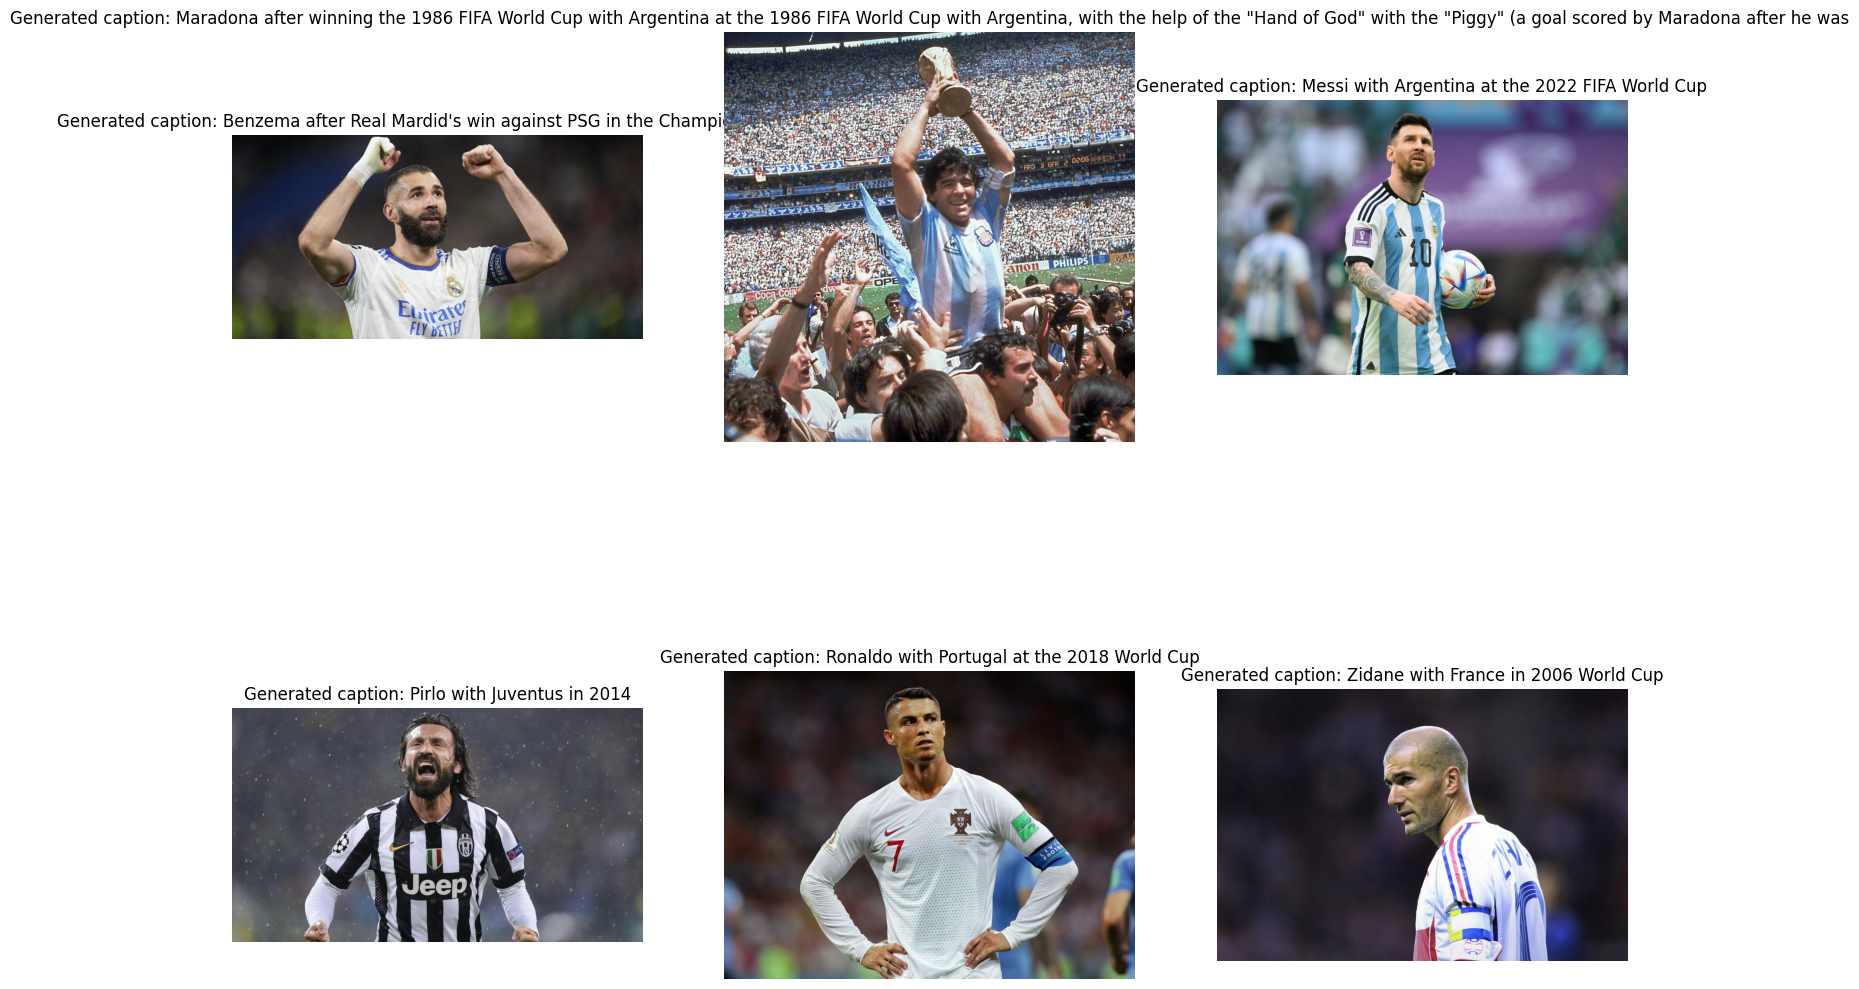

In [13]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")

## Push to Hub

In [13]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [14]:
model.push_to_hub("ybelkada/blip2-opt-2.7b-football-captions-adapters")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ybelkada/blip2-opt-2.7b-football-captions-adapters/commit/94febcd3b3278e1dbd3d72f7902b03fedeb4bede', commit_message='Upload model', commit_description='', oid='94febcd3b3278e1dbd3d72f7902b03fedeb4bede', pr_url=None, pr_revision=None, pr_num=None)

## Load from the Hub
<!-- Once trained you can push the model and processor on the Hub to use them later. 
Meanwhile you can play with the model that we have fine-tuned!
Please restart the runtime to run the cell below! -->
训练完成后, 您可以将 model 和 processor 推送到 Hub 上, 以便稍后使用。
同时, 您可以使用我们微调过的模型!
请重新运行, 以运行下面的单元!

In [ ]:
if model_name == "blip-image-captioning-base":
    from transformers import BlipForConditionalGeneration, AutoProcessor
    
    model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
    processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

elif model_name == "blip2-opt-2.7b":
    from transformers import Blip2ForConditionalGeneration, AutoProcessor
    from peft import PeftModel, PeftConfig
    
    peft_model_id = "ybelkada/blip2-opt-2.7b-football-captions-adapters"
    config = PeftConfig.from_pretrained(peft_model_id)
    
    model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto")
    model = PeftModel.from_pretrained(model, peft_model_id)
    
    processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")